In [1]:
import pandas as pd

import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
import umap
from yellowbrick.text import UMAPVisualizer
plt.rcParams['font.family'] = 'AppleGothic'

# 음수 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [2]:
all_data=pd.read_csv('data/df_traditional.csv')
# 데이터 열들 str 변환 후 양옆 공백 제거
all_data.columns = all_data.columns.str.strip()
all_data = all_data[['TEAM_WITH_SEASON'] + [col for col in all_data.columns if col != 'TEAM_WITH_SEASON']]
all_data.head()
orgin_df=all_data.copy()

In [3]:
all_data.columns

Index(['TEAM_WITH_SEASON', 'PLAYER', 'TEAM', 'AGE', 'GP', 'W', 'L', 'MIN',
       'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%',
       'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2',
       'TD3', '+/-', 'SEASON', 'TOTAL_MIN'],
      dtype='object')

# 1. feature selection with domain
- `삭제할 변수:'PLAYER','W','L','TEAM','AGE', 'FGM', 'FGA','3PM','FTM','3PA','REB','GP','DD2','TD3','TOTAL_MIN','FP'`

- 효율성을 중요하게 여기는 농구이므로 야투 시도횟수나 성공개수는 제외
- 더블더블과 트리플 더블은 희소 데이터이기 때문에 이를 제외 
- 리바운드 전체를 보기보다, 수비리바, 공격리바를 따로 봄으로써 수비에 적극적인지 공격에 적극적인지 판단할 수 있음 
- lebron james처럼 나이가 들수록 더 잘하는 선수가 있는 반면, nba는 장수하기 힘든 리그이기 때문에 나이로 판단하지 않기로 결정

In [4]:
all_data.drop(['PLAYER','W','L','TEAM','AGE', 'FGM', 'FGA','3PM','FTM','3PA','REB','GP','DD2','TD3','TOTAL_MIN','FP'], axis=1, inplace=True)

# 최대 행 출력 수를 늘림
pd.set_option('display.max_columns', None)
all_data.head()

,TEAM_WITH_SEASON,MIN,PTS,FG%,3P%,FTA,FT%,OREB,DREB,AST,TOV,STL,BLK,PF,+/-,SEASON
0,2000-01Allen Iverson,41.9,31.1,42.0,32.0,10.1,81.4,0.7,3.1,4.6,3.3,2.5,0.3,2.1,5.2,2000-01
1,2000-01Jerry Stackhouse,40.1,29.8,40.2,35.1,10.1,82.2,1.2,2.7,5.1,4.1,1.2,0.7,2.0,-0.8,2000-01
2,2000-01Shaquille O'Neal,39.5,28.7,57.2,0.0,13.1,51.3,3.9,8.8,3.7,2.9,0.6,2.8,3.5,6.3,2000-01
3,2000-01Kobe Bryant,41.0,28.5,46.4,30.5,8.2,85.3,1.5,4.3,5.0,3.2,1.7,0.6,3.3,5.4,2000-01
4,2000-01Vince Carter,39.7,27.6,46.0,40.8,6.7,76.5,2.3,3.2,3.9,2.2,1.5,1.1,2.7,4.3,2000-01


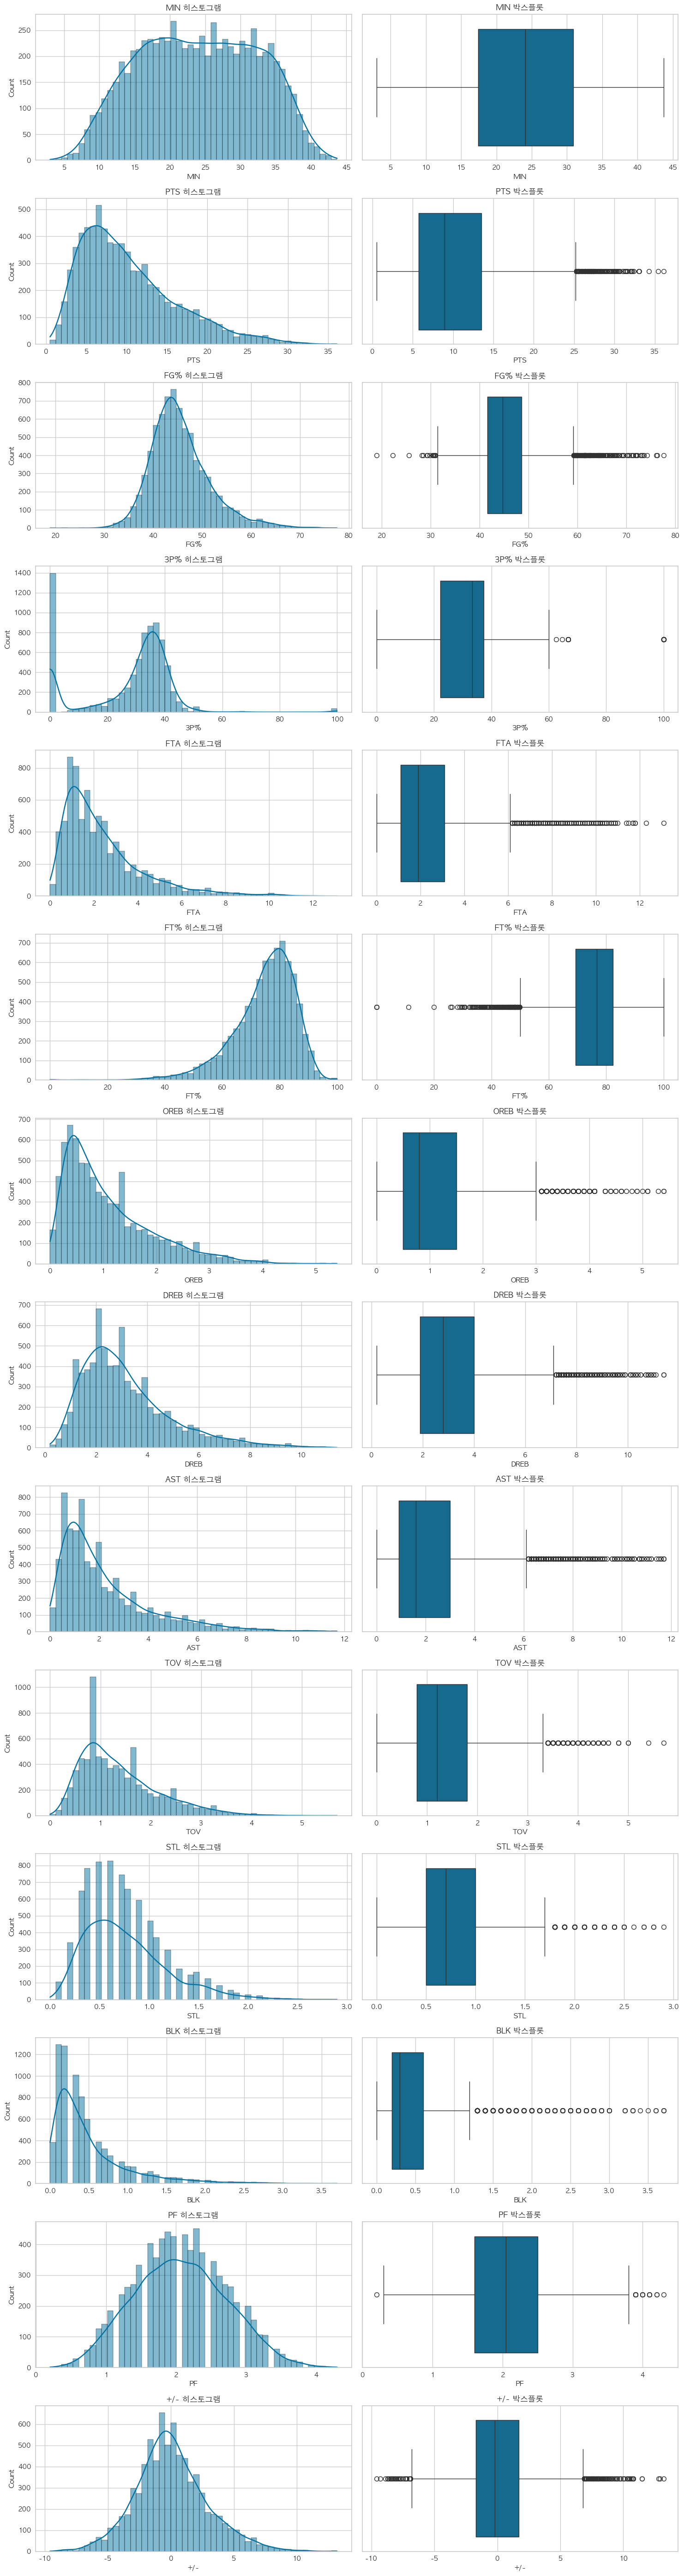

In [5]:
# 시각화함수 설정
def visualize_data(df):
    numeric_vars = df.select_dtypes(include='number').columns.tolist()

    if not numeric_vars:
        print("수치형 변수가 없습니다.")
        return

    # 변수 개수에 맞게 서브플롯 생성
    fig, axes = plt.subplots(len(numeric_vars), 2, figsize=(15, len(numeric_vars) * 4))

    # 수치형 변수마다 시각화
    for i, var in enumerate(numeric_vars):
        # 히스토그램
        sns.histplot(df[var], bins=50, kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'{var} 히스토그램')

        # 박스플롯
        sns.boxplot(x=df[var], ax=axes[i, 1])
        axes[i, 1].set_title(f'{var} 박스플롯')

    plt.tight_layout()
    plt.show()


# 시각화 함수 사용
visualize_data(all_data)


# 2. 데이터 전처리 - (1) 변수변환, 스케일링
- 데이터의 왜곡(Skewness)을 줄이고 분포를 정규 분포에 가깝게 만들기 위해 'Yeo-Johnson' 변환 수행
    - boxcox와 유사한 변환이지만, 양수와 0, 음수 데이터 모두 적용 가능.
    - boxcox는 양수 데이터에만 적용 가능. (변환 공식에 로그 변환이 포함되기 때문)
- 변수 변환 후에도 분포의 비대칭성과 왜도가 여전히 남아있는 변수에 대해:
    - 큰 이상치의 영향이 클러스터링에 반영되어 선수 군집이 만들어지기를 원하므로 추가적인 변수 변환을 수행하지 않음.
        - 즉, 이상치 데이터가 특이점을 가진 선수를 뽑기 위해 필요하다고 판단하고 이상치를 아예 없애려고 하지 않음. 겉ㅇ
    - 분포의 정규성이 PCA와 클러스터링 진행시 큰 문제가 없을 것이라고 판단.
    - 다만 PCA와 클러스터링은 데이터의 스케일에 영향을 크게 받으므로 이후 스케일링 진행.
- 피처 스케일링
    - StandardScaling, MinMaxScaling, RobustScaling 중 StandardScaling 진행.



> StandardScaling: 각 피처의 평균을 0, 표준편차를 1로 맞춤

> MinMaxScaling: 모든 피처를 0과 1 사이의 값으로 변환

> RobustScaling: 중앙값(median)과 사분위수(IQR)를 사용하여 스케일링

In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7554 entries, 0 to 7553
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TEAM_WITH_SEASON  7554 non-null   object 
 1   MIN               7554 non-null   float64
 2   PTS               7554 non-null   float64
 3   FG%               7554 non-null   float64
 4   3P%               7554 non-null   float64
 5   FTA               7554 non-null   float64
 6   FT%               7554 non-null   float64
 7   OREB              7554 non-null   float64
 8   DREB              7554 non-null   float64
 9   AST               7554 non-null   float64
 10  TOV               7554 non-null   float64
 11  STL               7554 non-null   float64
 12  BLK               7554 non-null   float64
 13  PF                7554 non-null   float64
 14  +/-               7554 non-null   float64
 15  SEASON            7554 non-null   object 
dtypes: float64(14), object(2)
memory usage: 94

In [7]:
all_data.columns

Index(['TEAM_WITH_SEASON', 'MIN', 'PTS', 'FG%', '3P%', 'FTA', 'FT%', 'OREB',
       'DREB', 'AST', 'TOV', 'STL', 'BLK', 'PF', '+/-', 'SEASON'],
      dtype='object')

In [8]:
import pandas as pd
from sklearn.preprocessing import PowerTransformer, StandardScaler

columns_to_transform = ['MIN', 'PTS', 'FG%', '3P%', 'FTA', 'FT%', 'OREB',
       'DREB', 'AST', 'TOV', 'STL', 'BLK', 'PF', '+/-']

# Yeo-Johnson 변환 적용 (전체 데이터)
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson')
all_data[columns_to_transform] = yeo_johnson_transformer.fit_transform(all_data[columns_to_transform])

# 연도별로 표준화 적용
scaler = StandardScaler()
all_data[columns_to_transform] = all_data.groupby('SEASON')[columns_to_transform].apply(lambda x: pd.DataFrame(scaler.fit_transform(x), columns=x.columns)).reset_index(drop=True)



# 3. 데이터 전처리- (2) 다중공선성 해결 및 차원 축소 - FA

In [10]:
from factor_analyzer import FactorAnalyzer
import numpy as np

# 데이터 표준화 (이미 표준화된 data를 사용)
# data = scaler.fit_transform(all_data)
data= all_data.copy()
data.drop(['TEAM_WITH_SEASON','SEASON'],axis=1, inplace=True)
# data.drop(['SEASON'],axis=1, inplace=True)

# FactorAnalyzer로 요인 분석 준비
fa = FactorAnalyzer(rotation=None)
fa.fit(data)

# 고윳값 가져오기
eigen_values, _ = fa.get_eigenvalues()

# 설명력 계산
explained_variance_ratio = eigen_values / np.sum(eigen_values)
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# 누적 설명력이 90% 이상일 때의 요인 개수 찾기
num_factors = np.argmax(cumulative_variance_ratio >= 0.8) + 1

# 결과 출력
print(f"누적 설명력이 80% 이상인 최소 요인 개수: {num_factors}")
print(f"누적 설명력: {cumulative_variance_ratio[num_factors - 1]:.4f}")

누적 설명력이 90% 이상인 최소 요인 개수: 5
누적 설명력: 0.8446


In [92]:
import pandas as pd
from factor_analyzer import FactorAnalyzer, Rotator

# 1. 요인의 개수 설정 후 요인 분석 수행
num_factors = 5 # 예시로 3개 요인 선택
fa_promax = FactorAnalyzer(n_factors=num_factors, rotation="varimax")
fa_promax.fit(data)
loadings_promax = fa_promax.loadings_

# 요인 로딩 행렬을 DataFrame으로 변환하고 cutoff 적용
cutoff = 0.3
loadings_promax_df = pd.DataFrame(loadings_promax, index=data.columns, columns=[f"Factor_{i+1}" for i in range(num_factors)])
loadings_promax_df_cutoff = loadings_promax_df.applymap(lambda x: x if np.abs(x) >= cutoff else 0)

# 2. Promax 회전된 로딩으로 요인 점수 계산 (transform 사용)
factor_scores = pd.DataFrame(fa_promax.transform(data), index=data.index, columns=[f"Factor_{i+1}" for i in range(num_factors)])

# 결과 확인 - 요인 간 상관 확인
print("Promax 회전 요인 로딩 (Cutoff 적용):\n", loadings_promax_df_cutoff)
print("요인 점수 간 상관관계:\n", factor_scores.corr()>0.7)

Promax 회전 요인 로딩 (Cutoff 적용):
       Factor_1  Factor_2  Factor_3  Factor_4  Factor_5
MIN   0.831281  0.328830  0.328899  0.000000  0.000000
PTS   0.793786  0.000000  0.483593  0.000000  0.000000
FG%   0.000000  0.617141  0.000000  0.000000  0.000000
3P%   0.000000 -0.428078  0.451372  0.000000  0.000000
FTA   0.717673  0.420302  0.000000  0.000000  0.308748
FT%   0.000000 -0.343690  0.493977  0.000000  0.000000
OREB  0.000000  0.896503  0.000000  0.000000  0.000000
DREB  0.464175  0.776582  0.000000  0.000000  0.000000
AST   0.908353  0.000000  0.000000  0.000000  0.000000
TOV   0.914055  0.000000  0.000000  0.000000  0.000000
STL   0.769215  0.000000  0.000000  0.000000  0.000000
BLK   0.000000  0.817740  0.000000  0.000000  0.000000
PF    0.423853  0.642509  0.000000  0.000000  0.000000
+/-   0.000000  0.000000  0.000000  0.750509  0.000000
요인 점수 간 상관관계:
           Factor_1  Factor_2  Factor_3  Factor_4  Factor_5
Factor_1      True     False     False     False     False
Factor_2    

/var/folders/gl/6qlsk6x94klgs54qzsg9q1jm0000gn/T/ipykernel_2921/4092744594.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  loadings_promax_df_cutoff = loadings_promax_df.applymap(lambda x: x if np.abs(x) >= cutoff else 0)



### 요인별 해석 및 변수명 제안

1. **Factor_1: Playmaker 능력**
   - **높은 로딩**: `MIN`, `PTS`, `FTA`, `AST`, `TOV`, `STL`
   - 이 요인은 선수의 **플레이 메이킹 능력** 
   - 득점(`PTS`), 자유투 시도(`FTA`), 어시스트(`AST`), 턴오버(`TOV`), 스틸(`STL`) 지표 높음 따라서, 게임의 흐름을 주도하고 공을 많이 다루는 플레이메이커로 해석
   - **제안된 변수명**: `Playmaker_Skill`

2. **Factor_2: 리바운드 능력**
   - **높은 로딩**: `FG%`, `OREB`, `DREB`, `PF`
   - 이 요인은 선수의 **리바운드 능력**과 관련이 깊습니다. 공격 및 수비 리바운드(`OREB`, `DREB`)와 필드골 성공률(`FG%`), 파울(`PF`)이 요인에 포함되어 있다. 따라서, 리바운드와 관련된 역할을 주로 하는 선수의 특성을 나타낸다.
   - 삼점슛과 자유투를 잘 못쏘는 것으로 보아 정통 센터의 특징을 가질 확률이 높다. 
   - **제안된 변수명**: `Center_skill`

3. **Factor_3: 슛 정확도**
   - **높은 로딩**: `3P%`, `FT%`, `PTS`
   - 이 요인은 선수의 **슛 정확도**와 관련이 깊습니다. 3점 슛 성공률(`3P%`), 자유투 성공률(`FT%`), 득점(`PTS`)이 포함되어 있어 슈팅 능력이 두드러진다고 해석할 수 있습니다.
   - **제안된 변수명**: `Shooting_Skill`

4. **Factor_4: 기여도**
   - **높은 로딩**: `+/-`
   - 이 요인은 팀에서의 **기여도**를 나타낸다.. `+/-`는 선수의 게임에서 팀에 미치는 영향을 나타내는 지표로, 팀의 전체적인 성과에 대한 기여도를 반영한다.
   - 하지만 해당 변수만 높고 다른 변수들의 수치가 낮기 때문에 주전 라인업이 강한 팀에서 뛰어 가비지 타임에 많이 출전하는 특징일 갖고 있다고 할 수 있다. 
   - **제안된 변수명**: `contribution`

5. **Factor_5: 자유투 기회 창출 능력**
   - **높은 로딩**: `FTA`
   - 이 요인은 자유투 시도(`FTA`)와 약하게 연결되어, **자유투 기회 창출**에 대한 특성을 나타낼 수 있습니다. 자유투
   - **제안된 변수명**: `FreeThrow_Opportunity`



In [93]:
# factor_scores.columns=['playmaker_skill','Center_skill','Shooting_Skill','team_contribution','freethrow_opportunity']
data=factor_scores.copy()
factor_scores.head()

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,1.727055,-0.223450,1.519291,0.890203,1.119777
1,1.876136,-0.009003,1.122463,-0.619987,1.493302
2,1.254795,1.962611,0.360562,1.407189,2.089061
3,1.609380,0.533254,1.119840,1.102198,0.932489
4,1.204731,0.750465,1.399962,1.078046,0.947967


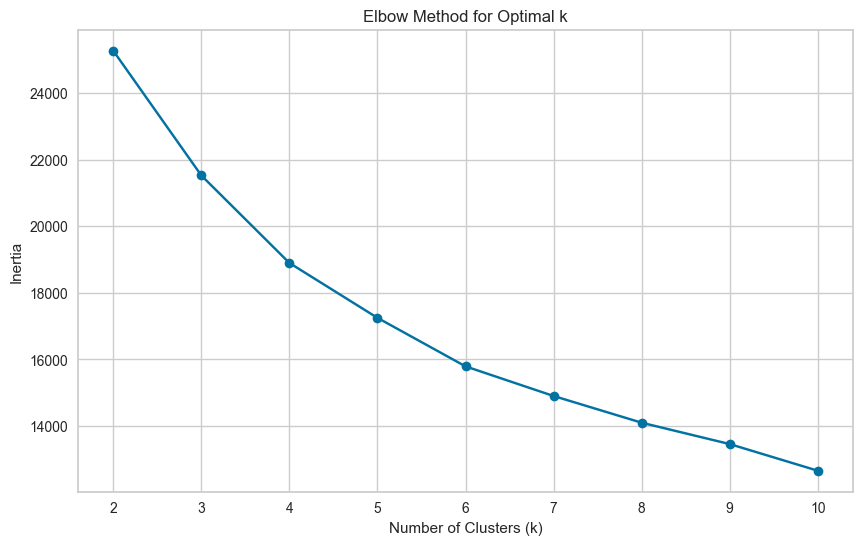

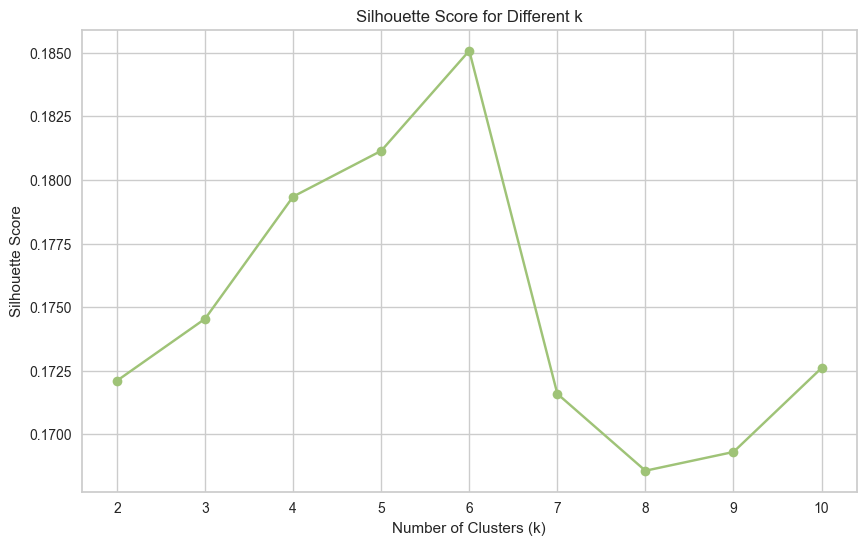

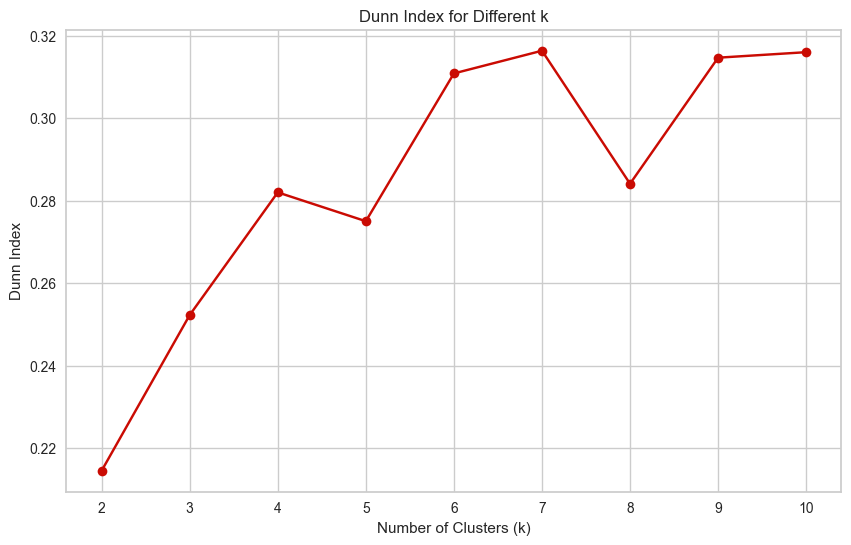

Silhouette Score 기준 최적의 k: 6
Dunn Index 기준 최적의 k: 7


In [94]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt


# Dunn Index 계산 함수 정의
def dunn_index(data, labels):
    unique_clusters = np.unique(labels)
    if len(unique_clusters) < 2:
        return np.nan
    centroids = [data[labels == i].mean(axis=0) for i in unique_clusters]
    dist_matrix = squareform(pdist(data))
    intra_distances = [dist_matrix[labels == i][:, labels == i].max() for i in unique_clusters]
    inter_distances = [np.linalg.norm(centroids[i] - centroids[j]) for i in range(len(centroids)) for j in range(i + 1, len(centroids))]
    return min(inter_distances) / max(intra_distances)

# K 범위 설정
k_values = range(2, 11)
inertia_scores = []  # 엘보우 메서드용
silhouette_scores = []  # 실루엣 점수 저장용
dunn_indices = []  # Dunn Index 저장용


# 각 k에 대해 KMeans 모델링 및 평가
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data)
    
    # 엘보우 메서드를 위한 관성 값 (inertia)
    inertia_scores.append(kmeans.inertia_)
    
    # 실루엣 점수 계산
    if len(set(labels)) > 1:
        silhouette_scores.append(silhouette_score(data, labels))
    else:
        silhouette_scores.append(np.nan)
    
    # Dunn Index 계산
    dunn_indices.append(dunn_index(data.to_numpy(), labels))

# 결과 시각화

# 1. 엘보우 메서드 시각화
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_scores, marker='o', color='b')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.xticks(k_values)
plt.grid(True)
plt.show()

# 2. 실루엣 점수 시각화
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='g')
plt.title("Silhouette Score for Different k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.grid(True)
plt.show()

# 3. Dunn Index 시각화
plt.figure(figsize=(10, 6))
plt.plot(k_values, dunn_indices, marker='o', color='r')
plt.title("Dunn Index for Different k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Dunn Index")
plt.xticks(k_values)
plt.grid(True)
plt.show()

# 최적의 k 찾기
optimal_k_silhouette = k_values[np.nanargmax(silhouette_scores)]
optimal_k_dunn = k_values[np.nanargmax(dunn_indices)]

print(f"Silhouette Score 기준 최적의 k: {optimal_k_silhouette}")
print(f"Dunn Index 기준 최적의 k: {optimal_k_dunn}")


In [95]:
fd_hac=data.copy()
kmeans = KMeans(n_clusters=6, random_state=42, max_iter=500)
labels = kmeans.fit_predict(data)
fd_hac['Cluster'] = labels

In [99]:
fd_hac['player']= orgin_df['TEAM_WITH_SEASON']
fd_hac['SEASON']= orgin_df['SEASON']
fd_hac.head()

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Cluster,player,SEASON
0,1.727055,-0.223450,1.519291,0.890203,1.119777,3,2000-01Allen Iverson,2000-01
1,1.876136,-0.009003,1.122463,-0.619987,1.493302,3,2000-01Jerry Stackhouse,2000-01
2,1.254795,1.962611,0.360562,1.407189,2.089061,3,2000-01Shaquille O'Neal,2000-01
3,1.609380,0.533254,1.119840,1.102198,0.932489,3,2000-01Kobe Bryant,2000-01
4,1.204731,0.750465,1.399962,1.078046,0.947967,3,2000-01Vince Carter,2000-01


In [101]:
x=fd_hac[fd_hac['SEASON']=='2022-23']
x[x['Cluster']==5]

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Cluster,player,SEASON
6944,0.112595,-0.561145,1.633523,0.283306,-0.183963,5,2022-23Jamal Murray,2022-23
6963,0.249923,-0.759573,1.171062,-0.021314,-0.015177,5,2022-23Bennedict Mathurin,2022-23
6966,-0.469064,-0.066570,1.668625,0.973366,-0.257733,5,2022-23Aaron Gordon,2022-23
6967,-0.143652,0.164113,1.302381,0.413710,-0.884151,5,2022-23Jaden Ivey,2022-23
6968,0.034292,-0.788647,0.936279,-0.187555,0.794614,5,2022-23Evan Mobley,2022-23
...,...,...,...,...,...,...,...,...
7192,-1.798765,-0.787957,0.665522,-0.658790,-1.429443,5,2022-23Isaiah Hartenstein,2022-23
7194,-1.586859,-0.695259,-0.107012,-0.016227,-0.886969,5,2022-23Austin Rivers,2022-23
7197,-1.774261,-1.301038,0.114711,0.152880,-0.875437,5,2022-23Danuel House Jr.,2022-23
7202,-1.961953,-0.938066,-0.837074,-0.089315,0.043996,5,2022-23Malachi Flynn,2022-23


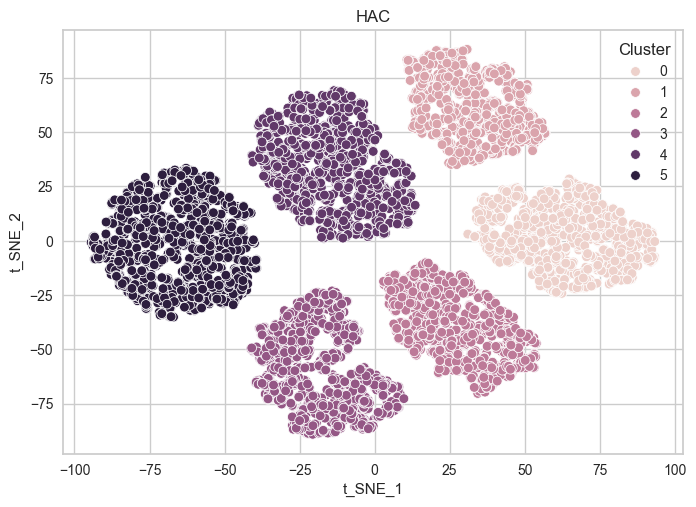

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


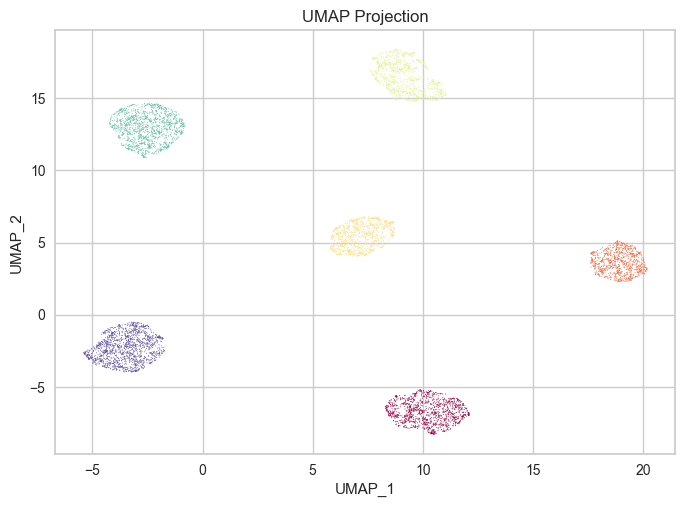

In [96]:
tsne = TSNE(n_components=2, perplexity=20)
data_2d = tsne.fit_transform(fd_hac)
df_data_2d = pd.DataFrame(data=data_2d, columns=["t_SNE_1", "t_SNE_2"])
df_data_2d["Cluster"] = fd_hac['Cluster']
#df_data_2d
sns_plot = sns.scatterplot(x="t_SNE_1", y="t_SNE_2", hue="Cluster", data=df_data_2d)
plt.title('HAC')   # 제목설정
plt.show()
standard_embedding = umap.UMAP(random_state=42).fit_transform(fd_hac)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c= fd_hac['Cluster'], s=0.1, cmap='Spectral')
plt.xlabel("UMAP_1")
plt.ylabel("UMAP_2")
plt.title("UMAP Projection")
plt.legend()
plt.show()

In [61]:
lis_df

,playmaker_skill,Center_skill,Shooting_Skill,team_contribution,freethrow_opportunity,Cluster
0,0.608000,-1.110559,-0.629992,-0.081575,-0.133756,0.0
1,-0.095414,0.317891,-0.392890,0.282830,-1.229742,1.0
2,0.572042,0.520726,0.477883,-0.994807,0.107406,2.0
3,0.981627,0.255366,0.665012,0.764539,0.377555,3.0
4,-0.736933,0.859648,-0.708107,-0.037902,0.485543,4.0
5,-0.929274,-0.693152,0.602367,0.034470,0.078076,5.0


# 클러스터 기반 선수 성향 분석

### 클러스터별 선수 성향

1. **Cluster 0: 수비에 집중하는 보조형**
   - **특징**: 중간 정도의 플레이메이킹 능력, 낮은 센터 및 슈팅 능력, 낮은 팀 기여도와 자유투 기회
   - **성향**: 이 클러스터의 선수들은 득점이나 리바운드보다는 상대 공격을 방어하고 수비에서 팀을 돕는 역할을 수행합니다. **수비에 집중하는 보조형 선수**
   - 비엘리트 가드, 수비형,패스형

2. **Cluster 1: 벤치에서 쏠쏠한 활약을 하는 포워드**
   - **특징**: 센터 능력과 팀 기여도가 중간 수준으로 긍정적, 슈팅과 자유투 기회 창출 능력은 낮음
   - **성향**: 이 클러스터는 리바운드와 팀 기여에 집중하며, 주로 센터 포지션에서 활약하는 선수들로 구성. **리바운드와 팀 기여에 중점을 둔 센터형**
   - 좋은 팀에서 가비지타임에 출전하는 센터, 후보센터

3. **Cluster 2: 공격과 플레이메이킹을 겸비한 다재다능형**
   - **특징**: 중간 정도의 플레이메이킹, 센터 및 슈팅 능력
   - **성향**: 다양한 포지션에서 역할을 소화할 수 있는 균형 잡힌 능력을 갖춘 선수,  특정 능력이 두드러지지는 않지만 공격과 수비에서 모두 기여할 수 있는 **다재다능형 선수**
   - 엘리트 가드 

4. **Cluster 3: 핵심 득점원과 팀 리더 역할**
   - **특징**: 높은 플레이메이킹과 슈팅 능력, 높은 팀 기여도, 적당한 자유투 기회
   - **성향**: 공격을 주도하고 팀을 이끄는 주요 득점원으로, 팀의 리더 역할을 수행합니다. **핵심 득점원 겸 팀 리더**로 해석할 수 있습니다.
   - 엘리트 포워드 및 센터 

5. **Cluster 4: 리바운드 및 페인트존 중심의 전통 센터형**
   - **특징**: 높은 센터 능력과 자유투 기회 창출 능력, 낮은 플레이메이킹과 슈팅 능력
   - **성향**: 페인트존에서 수비와 리바운드에 중점을 두는 전통적인 센터 역할을 수행하는 선수들입니다. **리바운드 및 페인트존 중심의 전통 센터형**
   - 골밑에서 서식하는 전통적인 센터지만 마무리 능력이 아쉬움. 리바운드 전문 센터
   - 리바운드 전문 센터 

6. **Cluster 5: 외곽 슈터형**
   - **특징**: 중간 수준의 슈팅 능력, 낮은 센터 및 플레이메이킹 능력, 중립적인 팀 기여도와 자유투 기회
   - **성향**: 슈팅 능력이 좋은 선수들로, 주로 외곽에서 득점에 기여하는 **외곽 슈터형 선수**
   - 외곽 슈터

---

### 요약

- **Cluster 0**: 수비엘리트 가드, 수비형,패스형
- **Cluster 1**: 좋은 팀에서 가비지타임에 출전하는 센터, 후보센터
- **Cluster 2**: 엘리트 가드
- **Cluster 3**: 엘리트 포워드
- **Cluster 4**: 리바운드 및 페인트존 중심의 전통 센터형
- **Cluster 5**: 외곽 슈터


In [62]:
lis={}
for i in range(6):
    lis[i]=fd_hac[fd_hac['Cluster'] == i].mean()

In [63]:
lis_df = pd.DataFrame(lis).T
lis_df

,playmaker_skill,Center_skill,Shooting_Skill,team_contribution,freethrow_opportunity,Cluster
0,0.608000,-1.110559,-0.629992,-0.081575,-0.133756,0.0
1,-0.095414,0.317891,-0.392890,0.282830,-1.229742,1.0
2,0.572042,0.520726,0.477883,-0.994807,0.107406,2.0
3,0.981627,0.255366,0.665012,0.764539,0.377555,3.0
4,-0.736933,0.859648,-0.708107,-0.037902,0.485543,4.0
5,-0.929274,-0.693152,0.602367,0.034470,0.078076,5.0


In [64]:
orgin_df['Cluster']=fd_hac['Cluster']
orgin_df.head()
orgin_df=orgin_df[['PLAYER'	,'SEASON'	,'TEAM'	,'Cluster',	'MIN']]